## 1) Packages and Data

Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import math
from numpy.random import choice
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import namedtuple, deque

import yfinance as yf

Get Market Data

In [2]:
ticker_symbol = "^GSPC" # ticker for s&p500

sp500 = yf.Ticker(ticker_symbol) # data for s&p500

hist = sp500.history(period="10y")

print(hist)

                                  Open         High          Low        Close  \
Date                                                                            
2014-05-23 00:00:00-04:00  1893.319946  1901.260010  1893.319946  1900.530029   
2014-05-27 00:00:00-04:00  1902.010010  1912.280029  1902.010010  1911.910034   
2014-05-28 00:00:00-04:00  1911.770020  1914.459961  1907.300049  1909.780029   
2014-05-29 00:00:00-04:00  1910.599976  1920.030029  1909.819946  1920.030029   
2014-05-30 00:00:00-04:00  1920.329956  1924.030029  1916.640015  1923.569946   
...                                ...          ...          ...          ...   
2024-05-16 00:00:00-04:00  5310.069824  5325.490234  5296.189941  5297.100098   
2024-05-17 00:00:00-04:00  5303.100098  5305.450195  5283.589844  5303.270020   
2024-05-20 00:00:00-04:00  5305.350098  5325.319824  5302.399902  5308.129883   
2024-05-21 00:00:00-04:00  5298.689941  5324.319824  5297.870117  5321.410156   
2024-05-22 00:00:00-04:00  5

Convert Data to CSV

In [3]:
# hist.to_csv("sp500_historical.csv")

Put CSV Data into Pandas Dataframe

In [4]:
csv = 'sp500_historical.csv'
df = pd.read_csv(csv,index_col=0) # use col 0 as row labels
type(df)

pandas.core.frame.DataFrame

## 2) Explore Data

In [5]:
df.shape

(2517, 7)

In [6]:
df.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-05-19 00:00:00-04:00,1876.660034,1886.000000,1872.420044,1885.079956,2664250000,0.0,0.0
2014-05-20 00:00:00-04:00,1884.880005,1884.880005,1868.140015,1872.829956,3007700000,0.0,0.0
2014-05-21 00:00:00-04:00,1873.339966,1888.800049,1873.339966,1888.030029,2777140000,0.0,0.0
2014-05-22 00:00:00-04:00,1888.189941,1896.329956,1885.390015,1892.489990,2759800000,0.0,0.0
2014-05-23 00:00:00-04:00,1893.319946,1901.260010,1893.319946,1900.530029,2396280000,0.0,0.0


Get statistics of data

In [7]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2517.000000,2517.000000,2517.000000,2517.000000,2.517000e+03,2517.0,2517.0
mean,3125.554992,3142.307463,3107.622268,3126.118749,3.969351e+09,0.0,0.0
std,951.181563,956.973539,945.492442,951.530421,9.650665e+08,0.0,0.0
min,1833.400024,1847.000000,1810.099976,1829.079956,1.296530e+09,0.0,0.0
25%,2185.169922,2188.060059,2179.419922,2186.479980,3.376750e+09,0.0,0.0
50%,2866.699951,2885.250000,2854.229980,2871.679932,3.793950e+09,0.0,0.0
75%,4013.020020,4046.459961,3980.310059,4016.219971,4.326660e+09,0.0,0.0
max,5310.069824,5325.490234,5296.189941,5308.149902,9.976520e+09,0.0,0.0


Plot stock movement

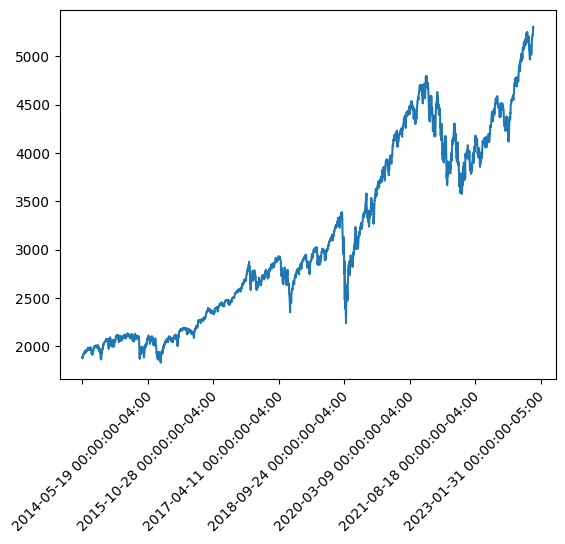

In [8]:
import matplotlib.dates as mdates
plt.plot(df.index, df['Close'])
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=1))
plt.show()

Data Cleaning

In [9]:
print('Null Values =', df.isnull().values.any()) # check for null values

Null Values = False


In [10]:
df = df.fillna(method='bfill') # if there are null values, replace them with the next value in the dataset

/var/folders/pd/9gc451qn4pq79vrqt_r9xlfr0000gn/T/ipykernel_41348/3377758463.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill') # if there are null values, replace them with the next value in the dataset


In [11]:
df.head(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-05-19 00:00:00-04:00,1876.660034,1886.000000,1872.420044,1885.079956,2664250000,0.0,0.0
2014-05-20 00:00:00-04:00,1884.880005,1884.880005,1868.140015,1872.829956,3007700000,0.0,0.0


Remove Last Two Colums

In [12]:
cols = df.columns.to_list() # converts columns of df into a list
drop = cols[-2:] # get last two columns of df
df = df.drop(columns=drop) # delete those columns

df.head(2)

,Open,High,Low,Close,Volume
Date,,,,,
2014-05-19 00:00:00-04:00,1876.660034,1886.000000,1872.420044,1885.079956,2664250000
2014-05-20 00:00:00-04:00,1884.880005,1884.880005,1868.140015,1872.829956,3007700000


## 3) Build Model

Split Dataset

In [13]:
X = list(df['Close']) # create a list of closing prices from df
X = [float(x) for x in X] # convert each element to a float

In [ ]:
print(X[0:10])

In [14]:
from sklearn.model_selection import train_test_split
test_size = 0.2
X_train, x_test = train_test_split(X, test_size=test_size, shuffle=False) # use test size 20%

In [ ]:
print(X_train[0:10])

Agent Class: Define an Agent that is designed to act as a reinforcement learning agent for stock trading using a neural network. The agent can buy, sell or hold a stock. It learns from its experiences over time

In [ ]:
class Agent(nn.Module):
    def __init__(self, state_size, is_eval=False, model_name=""):
        super(Agent, self).__init__()
        self.state_size = state_size # state_size is equal to the window size; n previous days
        self.action_size = 3 # buy, hold, sell
        self.memory = deque(maxlen=1000) # for holding past experiences
        self.inventory = [] # keep track of bought stocks
        self.model_name = model_name # name of the model used for saving or loading
        self.is_eval = is_eval # indicate if model is in eval mode

        self.model = self._model() # initialize model
        if is_eval and model_name: # or load saved one if it is requested
            self.load_model(model_name)
        
        # instead of using compile() in tensorflow, specify parameters manually
        self.criterion = nn.MSELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        self.gamma = 0.95 # discount factor for future rewards
        self.epsilon = 1.0 # initial exploration rate for the epsilon-greedy policy
        self.epsilon_min = 0.1 # minimum value of epsilon
        self.epsilon_decay = 0.995 # decay rate for epsilon

    def load_model(self, model_name):
        self.model.load_state_dict(torch.load(model_name)) # load model
        self.model.eval() # set to eval mode

    # create the model
    def _model(self):
        model = nn.Sequential(
            # input layer w/ReLU
            nn.Linear(in_features=self.state_size, out_features=64),
            nn.ReLU(),
            # hidden layers w/ReLU
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=8),
            nn.ReLU(),
            # output layer w/linear (no activation)
            nn.Linear(in_features=8, out_features=self.action_size)
        )
        return model

    # forward pass through the layers
    def forward(self, x):
        return self.model(x)
    
    # select an action
    def act(self, state):
        # if it is test mode and self.epsilon is still very high, select a random action
        num = random.random()
        if not self.is_eval and num <= self.epsilon:
            val = random.randrange(self.action_size)
            return val
        # otherwise select the action that has the highest predicted value from the neural network (q-value function)
        state = torch.tensor(state, dtype=torch.float32)
        options = self.forward(state).detach().numpy()
        return np.argmax(options[0])

    # train the neural network on a batch of data 
    def train(self, X, y):
        self.model.train() # set model to training mode
        self.optimizer.zero_grad() # set gradients to zero

        y_pred = self.forward(X) # forward pass

        loss = self.criterion(y_pred, y) # calculate loss using criterion defined in attributes

        loss.backward() # backward pass to calculate gradients
        self.optimizer.step() # update parameters

        return loss.item() # return loss

    # experience replay
    # this helps the agent learn from past experiences.  
    # It samples a minibatch of experiences from memory and updates Q-values using bellman equation
    # if the current epoch is not done, update the target with the discounted future reqard
    # after training on the minibatch, it decays the exploration rate epsilon
    def expReplay(self, batch_size):
        # sample transitions from batch randomly so that they are decorrelated
        mini_batch = random.sample(self.memory, batch_size) 
        total_loss = 0
        
        # process each experience in the mini batch
        for state, action, reward, next_state, done in mini_batch:
            state = torch.tensor(state, dtype=torch.float32) # convert state to pytorch tensor
            next_state = torch.tensor(next_state, dtype=torch.float32) # convert next_state to pytorch tensor
            target = reward # set target as the imediate reward recieved after taking the action

            # updating target q value: if the episode is not done, then the target q-value is updated
            if not done:
                # bellman equation: V(s) = max(R(s,a) + yV(s))
                # value of state = max(reward for being in state s and performing action a + discount_factor*value of state)
                n_s = self.forward(next_state) # pass next_state through the neural network to get the predicted q-values for next_state
                # target q-value is updated using target = reward + gamma*max_future_reward
                # torch.max(n_s[0]) gets the maximum q-value from the predicted q-values, representing the maximum expected future reward
                target = reward + self.gamma * torch.max(n_s[0]) 

            target_f = self.forward(state) # pass the current state through the neural network to get the predicted q-values
            # update predicted q value for the taken action with the calculated target q-value
            # this essentially adjusts the q-value for the specific action taken, while oher actions' q-values remain the same
            target_f[0][action] = target 

            # train the neural network
            loss = self.train(state, target_f)
            total_loss += loss
        avg_loss = total_loss / batch_size
        # if the current exploration rate epsilon is greater than the minimum allowed exploration rate epsilon min,
        # then it is decayed
        # this gradually shifts the policy from exploration (random actions) to exploitation (choosing the best known action)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        
        return avg_loss

Helper Functions

In [ ]:
# given a number n, format it with a dollar sign and a negative if needed
def formatPrice(n):
    return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# custom sigmoid function that doesn't need tensor for input
def sigmoid(x):
    if x >= 0:
        return 1 / (1 + math.exp(-x))
    else:
        return 1 / (1 + math.exp(x))

# construct a window of the last n datapoints ending at time t
# data is the list of historical stock prices, t is the current time index, n is the window size
def getState(data, t, n):
    d = t - n + 1 # starting index of the window
    block = data[d:t+1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # create the data block including t
    res = [] # store normalized differences between consecutive data points
    for i in range(n-1): # loop over the window of data points excluding the last point
        res.append(sigmoid(block[i+1]-block[i])) # compute the difference block[i+1]-block[i], apply sigmoid, and append to res
    return np.array([res]) # return res as a numpy array

# visualize trading behavior of the agent
# states_buy is a list of indices where the agent decided to buy
# states_sell is a list of indices where the agent decided to sell
# profit is total profit made by agent
def plot_behavior(data_input, states_buy, states_sell, profit):
    fig = plt.figure(figsize=(15,5))
    plt.plot(data_input, color='g', lw=2.) # plot stock prices in red with line width of 2
    plt.plot(data_input, '^', markersize=10, color='m', label='Buying Signal', markevery=states_buy) # mark buying signals with up arrows
    plt.plot(data_input, 'v', markersize=10, color='k', label='Selling Signal', markevery=states_sell) # mark selling signals with down arrows
    plt.title('Total Gains: %f'%(profit)) # print total gains
    plt.legend() # add a legend to plot
    plt.show() # show the plot

Function to train the Agent

In [ ]:
def train_agent(window_size: int, agent: Agent, data, l: int, batch_size: int, epochs: int):
    for e in range(epochs+1): 
        print("Epoch " + str(e) + "/" + str(epochs)) 

        state = getState(data, 0, window_size + 1) # initialize the initial state for the current epoch 
        total_profit = 0 # reset total profit
        agent.inventory = [] # reset inventory of agent
        states_buy = [] # reset list of indices where agent bought
        states_sell = [] # reset list of indices where agent sold
        epoch_loss = 0 # total loss for epoch
        loss_count = 0 # number of minibatches processed

        for t in range(l): # loop through each time step in the train data
            action = agent.act(state) # decide what action to take based on the current state

            # calculate the next state at the next time step,
            # include the current time step and the previous window size in the new window size
            next_state = getState(data, t+1, window_size+1)  
        
            reward = 0 # initialize the reward to zero

            # agent chooses to buy
            if action == 1: 
                agent.inventory.append(data[t]) # add bought stock price to inventory
                states_buy.append(t) # record buying time step t

            # agent chooses to sell, and it has already bought a stock
            elif action == 2 and len(agent.inventory) > 0: 
                bought_price = agent.inventory.pop(0) # get the price of the last stock bought, remove from inventory
                reward = max(data[t] - bought_price, 0) # get the reward of selling the stock, either positive or zero
                total_profit += (data[t] - bought_price) # add the profit from selling the stock to total_profit
                states_sell.append(t) # record selling time step t
            
            # check if the current time step is the last one to signal the end of the epoch
            done = True if t == l - 1 else False 

            # add the tuple with information to the memory of the agent; store the experience in memory 
            # an experience represents one step in the environment
            transition = (state, action, reward, next_state, done)
            agent.memory.append(transition) 
            state = next_state # update the current state to the next state

            if done: # visualize the total profit and plot the buying/selling signals if epoch is done 
                print("--------------------------------")
                print("Total Profit: " + formatPrice(total_profit))
                print("--------------------------------")
                plot_behavior(data, states_buy, states_sell, total_profit)

            # if the number of experiences stored is greater than batch_size
            if len(agent.memory) > batch_size: 
                batch_loss = agent.expReplay(batch_size)
                if batch_loss is not None: # sometimes batch_loss is None, this is to avoid error
                    epoch_loss += batch_loss
                    loss_count+=1

        if loss_count > 0:
            avg_epoch_loss = epoch_loss / loss_count
            print(f"Average Loss for Epoch {e}: {avg_epoch_loss}")
    
    torch.save(agent.model.state_dict(), ("model_ep"+str(e)))

## 4) Train Model

In [ ]:
window_size = 1 # size of window to construct state
agent = Agent(window_size) # create an instance of Agent class
data = X_train # get training data
l = len(data)-1 # length of training data
batch_size = 32 # size of mini batch used in experienceReplay; the nubmer of experiences the agent will use for each step in experienceReplay/training
epochs = 15 # number of loops over whole dataset

## Results

In [ ]:
from torchsummary import summary
summary(agent.model, input_size=(agent.state_size,))

In [ ]:
test_data = x_test
l_test = len(test_data) - 1
window_size = 1
model_name = "model_ep"+str(epochs)

is_eval = True

eval_agent = Agent(window_size, is_eval, model_name)

state = getState(data, 0, window_size + 1)
total_profit = 0
states_buy_test = []
states_sell_test = []

In [ ]:
for t in range(l_test):
    action = eval_agent.act(state)
    next_state = getState(test_data, t + 1, window_size + 1)
    reward = 0
    
    if action == 1:
        eval_agent.inventory.append(test_data[t])
        states_buy_test.append(t)
        print("Buy: ", formatPrice(test_data[t]))
    elif action == 2 and len(eval_agent.inventory) > 0:
        bought_price = eval_agent.inventory.pop(0)
        reward = max(test_data[t] - bought_price, 0)
        total_profit += (test_data[t] - bought_price)
        states_sell_test.append(t)
        print("Sell: ", formatPrice(test_data[t]))
        print("Profit: ", formatPrice(test_data[t] - bought_price))
    
    done = True if t == l_test - 1 else False
    state = next_state
    
    if done:
        print("------------------------------------------")
        print("Total Profit: " + formatPrice(total_profit))
        print("------------------------------------------")
        
plot_behavior(test_data,states_buy_test, states_sell_test, total_profit)